# ProjectWork Deep Learning
https://www.kaggle.com/competitions/mlnomads-mlolympiad24/overview

## Import Libraries

In [22]:
import os
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.auto import tqdm
from PIL import Image

## Data Loading

In [2]:
# Clone the repo
!git clone https://github.com/ireneburri/PW_DeepLearning.git

%cd PW_DeepLearning

Cloning into 'PW_DeepLearning'...
remote: Enumerating objects: 18, done.
remote: Total 18 (delta 0), reused 0 (delta 0), pack-reused 18 (from 3)
Receiving objects: 100% (18/18), 245.94 MiB | 16.55 MiB/s, done.
Updating files: 100% (5/5), done.
/content/PW_DeepLearning


In [3]:
!ls Data

Image2.zip  Images1.zip  Masks.zip


In [8]:
# Unzip all 3 files
!unzip /content/PW_DeepLearning/Data/Masks.zip -d Data/Masks
!unzip /content/PW_DeepLearning/Data/Images1.zip -d Data/Images
!unzip /content/PW_DeepLearning/Data/Images2.zip -d Data/Images

Output streaming troncato alle ultime 5000 righe.
  inflating: Data/Masks/Masks/water_body_1812.jpg  
  inflating: Data/Masks/Masks/water_body_1813.jpg  
  inflating: Data/Masks/Masks/water_body_1814.jpg  
  inflating: Data/Masks/Masks/water_body_1815.jpg  
  inflating: Data/Masks/Masks/water_body_1816.jpg  
  inflating: Data/Masks/Masks/water_body_1817.jpg  
  inflating: Data/Masks/Masks/water_body_1818.jpg  
  inflating: Data/Masks/Masks/water_body_1819.jpg  
  inflating: Data/Masks/Masks/water_body_182.jpg  
  inflating: Data/Masks/Masks/water_body_1820.jpg  
  inflating: Data/Masks/Masks/water_body_1822.jpg  
  inflating: Data/Masks/Masks/water_body_1823.jpg  
  inflating: Data/Masks/Masks/water_body_1824.jpg  
  inflating: Data/Masks/Masks/water_body_1825.jpg  
  inflating: Data/Masks/Masks/water_body_1826.jpg  
  inflating: Data/Masks/Masks/water_body_1827.jpg  
  inflating: Data/Masks/Masks/water_body_1828.jpg  
  inflating: Data/Masks/Masks/water_body_1829.jpg  
  inflating: Da

In [ ]:
# # !apt-get install git
# repo_url = 'https://github.com/username/repo_name.git'  ##########
# !git clone $repo_url

# repo_name = repo_url.split('/')[-1].replace('.git', '')
# repo_path = f'/content/{repo_name}'

# # Check contents
# print(f"Dataset cloned into: {repo_path}")
# print("\nListing the files and folders inside the dataset:")

# for root, dirs, files in os.walk(repo_path):
#     level = root.replace(repo_path, '').count(os.sep)
#     indent = ' ' * 4 * (level)
#     print(f'{indent}{os.path.basename(root)}/')
#     subindent = ' ' * 4 * (level + 1)
#     for f in files:
#         print(f'{subindent}{f}')

# images_folder = os.path.join(repo_path, 'train')

# if os.path.exists(images_folder):
#     img_files = [f for f in os.listdir(images_folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))][:5]

#     plt.figure(figsize=(15,5))
#     for idx, img_file in enumerate(img_files):
#         img_path = os.path.join(images_folder, img_file)
#         img = mpimg.imread(img_path)
#         plt.subplot(1,5,idx+1)
#         plt.imshow(img)
#         plt.title(img_file)
#         plt.axis('off')
#     plt.show()
# else:
#     print(f"No images folder found at {images_folder}")

In [28]:
IMG_DATA = "/content/PW_DeepLearning/Data/Images"
MASK_DATA = "/content/PW_DeepLearning/Data/Masks"
# IMAGES =  next(os.walk(IMG_DATA))[2]
# MASKS = next(os.walk(MASK_DATA))[2]

In [30]:
# Pick one file (for example, the first one)
import cv2
img_file = os.listdir(IMG_DATA)[0]   # take the first image
mask_file = os.listdir(MASK_DATA)[0] # take the first mask

# Full paths
img_path = os.path.join(IMG_DATA, img_file)
mask_path = os.path.join(MASK_DATA, mask_file)

# Load images
img = cv2.imread(img_path)        # Read with OpenCV (BGR format)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Masks are usually grayscale

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].imshow(img)
axs[0].set_title('Image')
axs[0].axis('off')

axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask')
axs[1].axis('off')

plt.show()

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


# Prova1


## Data Exploration

In [24]:
print(f"There are total of {len(IMAGES)} images and {len(MASKS)} masks in the given dataset.")

There are total of 0 images and 0 masks in the given dataset.


IndexError: list index out of range

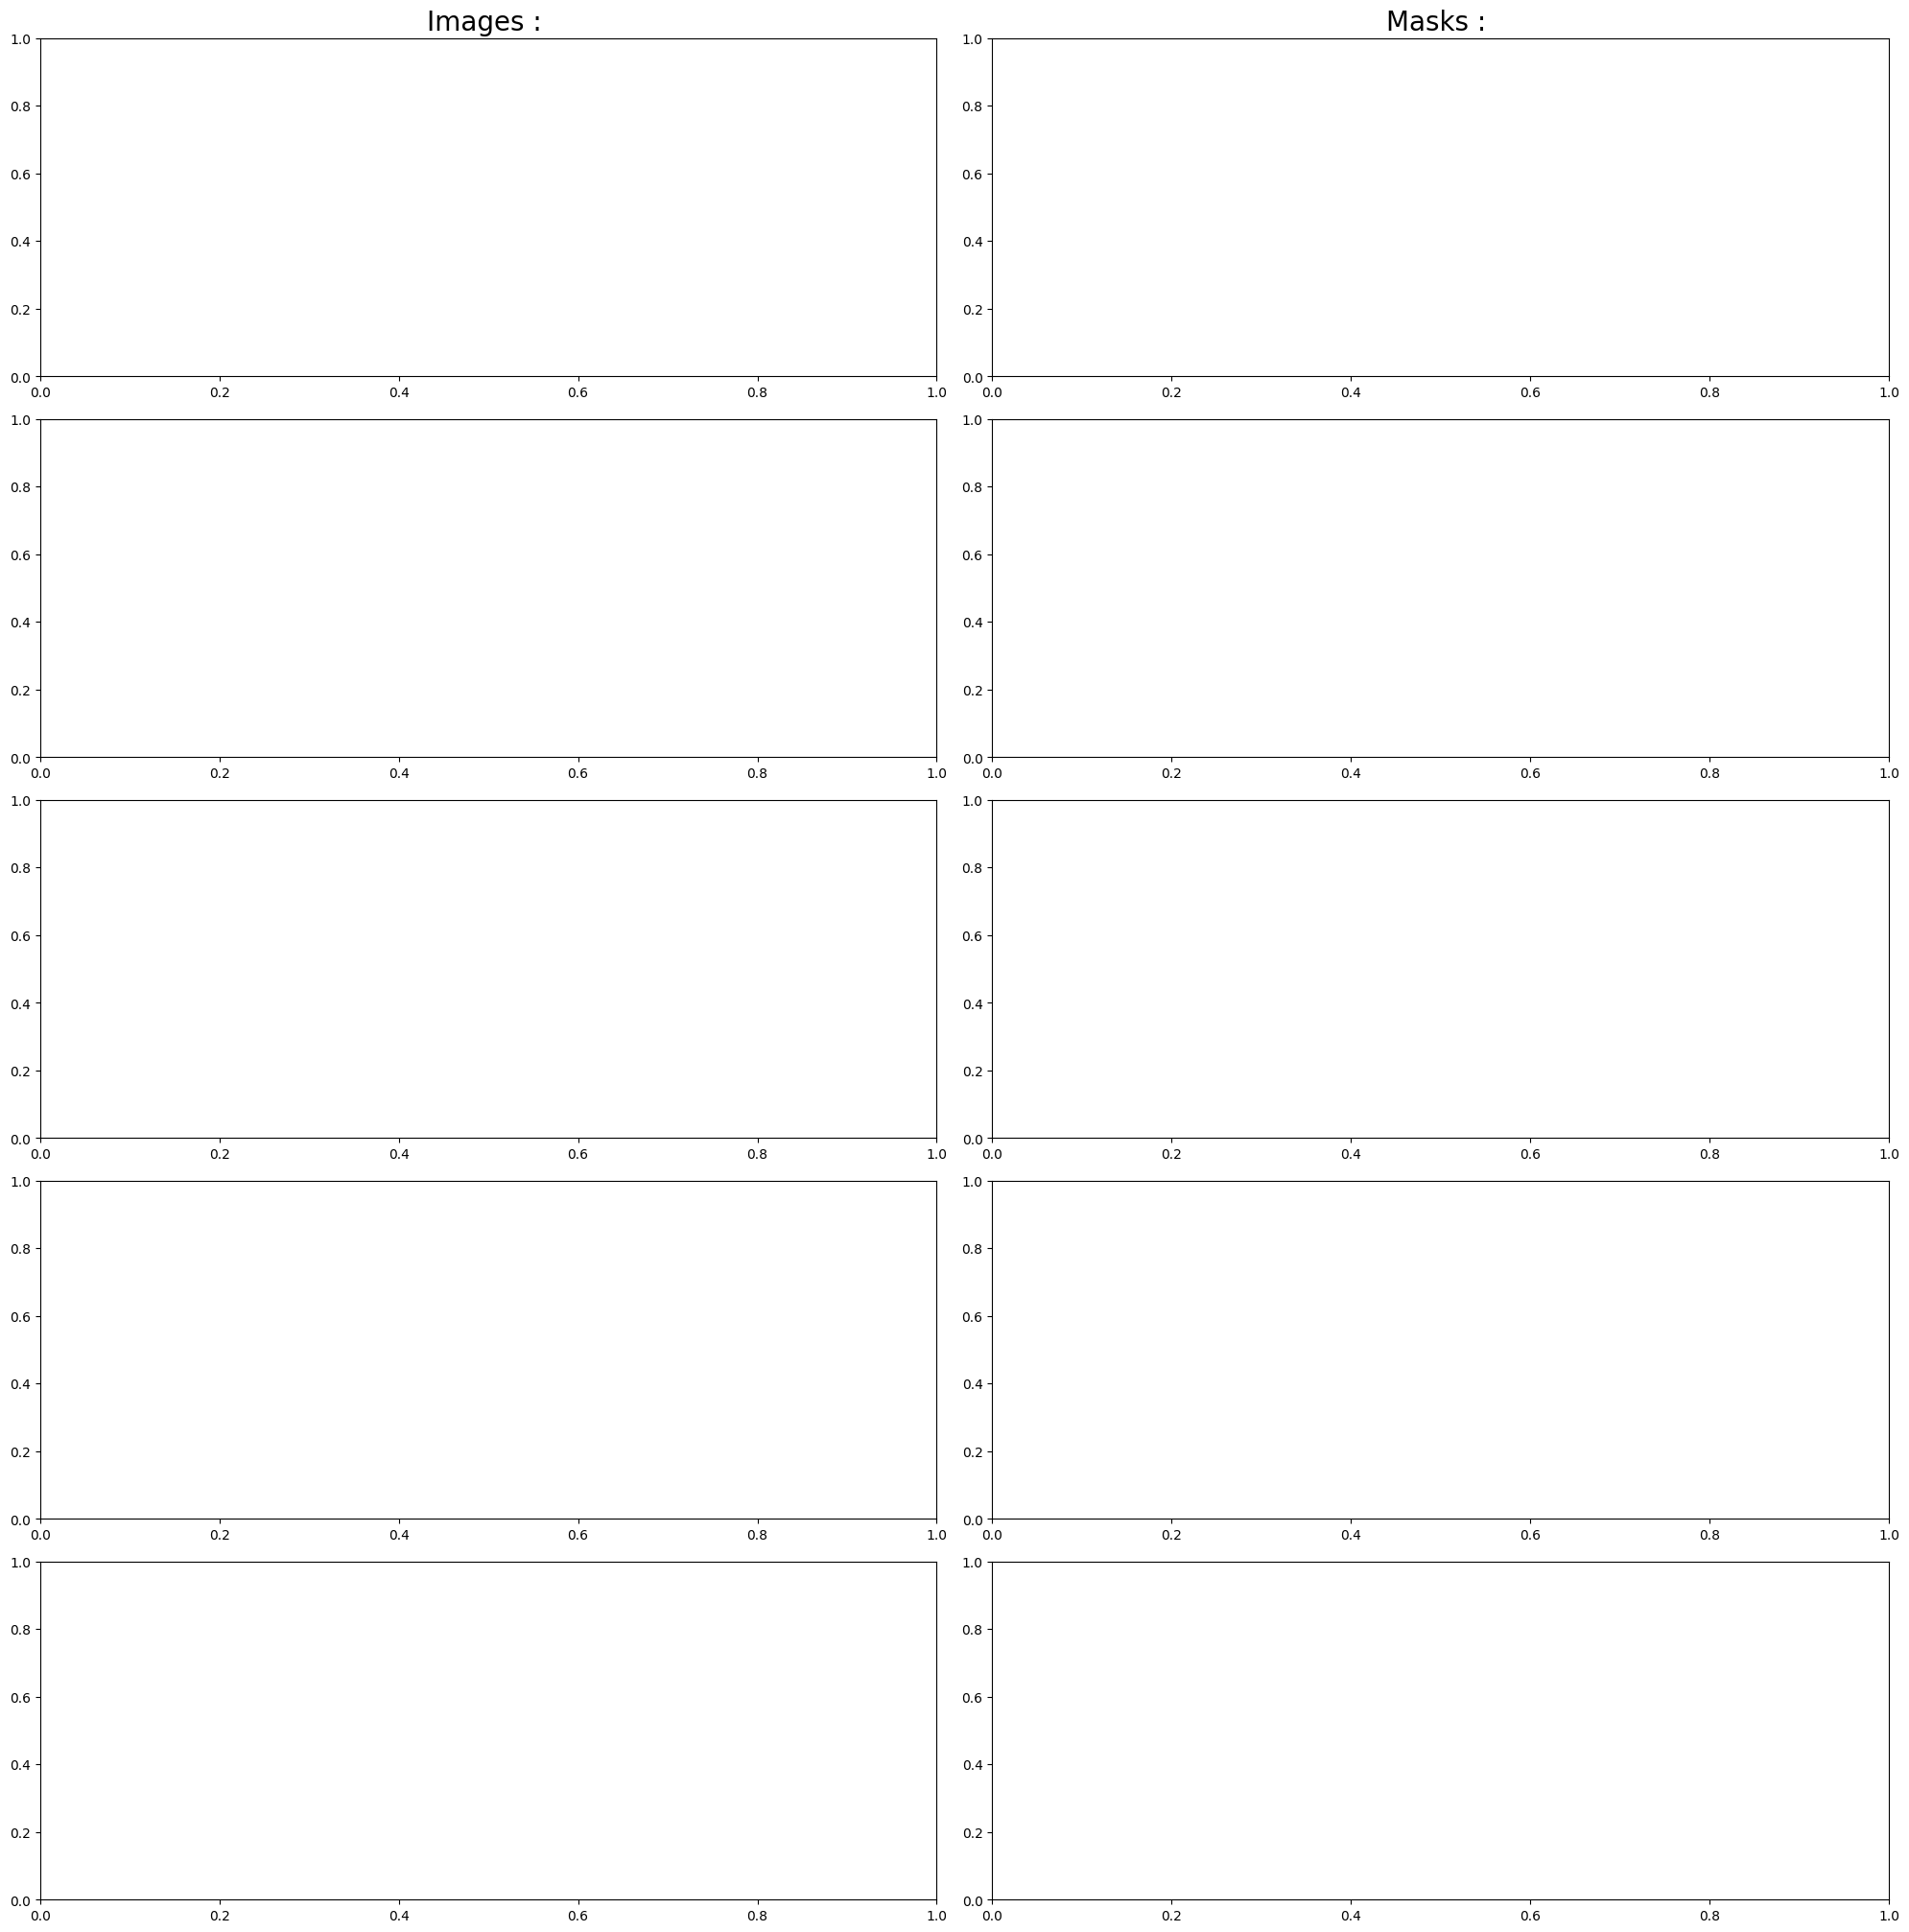

In [26]:
# Randomly generates 5 images and their corresponding masks
indeces = np.random.randint(0, len(IMAGES), 5)

fig, ax = plt.subplots(5, 2, figsize=(20, 20))
fig.tight_layout()
ax[0, 0].set_title("Images : ", fontsize=20)
ax[0, 1].set_title("Masks : ", fontsize=20)
for i, idx in enumerate(indeces):
    image = Image.open(IMG_DATA + "/" + IMAGES[idx])
    mask = Image.open(MASK_DATA + "/" + MASKS[idx])
    image = image.resize((256, 256))
    mask = mask.resize((256, 256))
    ax[i, 0].imshow(image)
    ax[i, 0].axis("off")
    ax[i, 1].imshow(mask)
    ax[i, 1].axis("off")

## Data Preparation

In [ ]:
# Split the data into train and validation sets
split_size = 0.2
last_idx = int(np.floor((1 - split_size) * len(IMAGES)))
X_train = IMAGES[:last_idx]
Y_train = MASKS[:last_idx]
X_val = IMAGES[last_idx:]
Y_val = MASKS[last_idx:]

In [ ]:
print(f"X_train contains {len(X_train)} images.")
print(f"Y_train contains {len(Y_train)} masks.")
print(f"X_val contains {len(X_val)} images.")
print(f"Y_val contains {len(Y_val)} masks.")

In [ ]:
# Load the image and mask data as numpy arrays for the model
def load_data(data, img_id):
    path = data + "/" + img_id
    image = Image.open(path).convert("RGB")
    image = image.resize((256, 256))
    return np.asarray(image, dtype=np.uint8)

X_train_transformed = np.zeros((len(X_train), 256, 256, 3), dtype=np.uint8)

X_val_transformed = np.zeros((len(X_val), 256, 256, 3), dtype=np.uint8)

print("Loading Train Images : ")
for i in tqdm(range(len(X_train))):
    X_train_transformed[i] = load_data(IMG_DATA, X_train[i])

print("Loading Validataion Images : ")
for j in tqdm(range(len(X_val))):
    X_val_transformed[j] = load_data(IMG_DATA, X_val[j])

In [ ]:
# For masks we will use Luminance method
def rgbtogray(image):
    image = np.dot(image, [0.2989, 0.5870, 0.1140])
    image = np.expand_dims(image, axis=-1)
    return image.astype(np.bool_)

Y_train_transformed = np.zeros((len(Y_train), 256, 256, 1), dtype=np.uint8)
Y_val_transformed = np.zeros((len(Y_val), 256, 256, 1), dtype=np.bool_)

print("Loading Train Masks : ")
for i in tqdm(range(len(Y_train))):
    Y_train_transformed[i] = rgbtogray(load_data(MASK_DATA, Y_train[i]))

print("Loading Validation Masks : ")
for j in tqdm(range(len(Y_val))):
    Y_val_transformed[j] = rgbtogray(load_data(MASK_DATA, Y_val[j]))

In [ ]:
print("The  shape of training images : ", X_train_transformed.shape)
print("The  shape of training masks : ", Y_train_transformed.shape)
print("The  shape of validation images : ", X_val_transformed.shape)
print("The  shape of validation masks : ", Y_val_transformed.shape)

## Model building

In [ ]:
# Base-UNET Model

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

# Model is divided into 3 sections called Encoder, Bottleneck, Decoder

inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
std_inputs = tf.keras.layers.Lambda(lambda x:x/255)(inputs)

### Encoder
# Convolutional block 1
conv1_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(std_inputs)
conv1_1 = tf.keras.layers.BatchNormalization()(conv1_1)
conv1_1 = tf.keras.layers.ReLU()(conv1_1)
conv1_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv1_1)
conv1_2 = tf.keras.layers.BatchNormalization()(conv1_2)
conv1_2 = tf.keras.layers.ReLU()(conv1_2)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1_2)

# Convolutional block 2
conv2_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(pool1)
conv2_1 = tf.keras.layers.BatchNormalization()(conv2_1)
conv2_1 = tf.keras.layers.ReLU()(conv2_1)
conv2_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv2_1)
conv2_2 = tf.keras.layers.BatchNormalization()(conv2_2)
conv2_2 = tf.keras.layers.ReLU()(conv2_2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2_2)

# Convolutional block 3
conv3_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(pool2)
conv3_1 = tf.keras.layers.BatchNormalization()(conv3_1)
conv3_1 = tf.keras.layers.ReLU()(conv3_1)
conv3_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv3_1)
conv3_2 = tf.keras.layers.BatchNormalization()(conv3_2)
conv3_2 = tf.keras.layers.ReLU()(conv3_2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3_2)

# Convolutional block 4
conv4_1 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(pool3)
conv4_1 = tf.keras.layers.BatchNormalization()(conv4_1)
conv4_1 = tf.keras.layers.ReLU()(conv4_1)
conv4_2 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv4_1)
conv4_2 = tf.keras.layers.BatchNormalization()(conv4_2)
conv4_2 = tf.keras.layers.ReLU()(conv4_2)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4_2)

### Bottleneck
bn_conv_1 = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(pool4)
bn_conv_1 = tf.keras.layers.BatchNormalization()(bn_conv_1)
bn_conv_1 = tf.keras.layers.ReLU()(bn_conv_1)
bn_conv_2 = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(bn_conv_1)
bn_conv_2 = tf.keras.layers.BatchNormalization()(bn_conv_2)
bn_conv_2 = tf.keras.layers.ReLU()(bn_conv_2)

### Decoder
# Reverse Convolutional Block 1
upconv1 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=(2, 2), strides=(2, 2), padding="same", kernel_initializer="he_normal")(bn_conv_2)
upconv1 = tf.keras.layers.Concatenate()([conv4_2, upconv1])
conv5_1 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(upconv1)
conv5_1 = tf.keras.layers.BatchNormalization()(conv5_1)
conv5_1 = tf.keras.layers.ReLU()(conv5_1)
conv5_2 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv5_1)
conv5_2 = tf.keras.layers.BatchNormalization()(conv5_2)
conv5_2 = tf.keras.layers.ReLU()(conv5_2)

# Reverse Convolutional Block 2
upconv2 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2), padding="same", kernel_initializer="he_normal")(conv5_2)
upconv2 = tf.keras.layers.Concatenate()([conv3_2, upconv2])
conv6_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(upconv2)
conv6_1 = tf.keras.layers.BatchNormalization()(conv6_1)
conv6_1 = tf.keras.layers.ReLU()(conv6_1)
conv6_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv6_1)
conv6_2 = tf.keras.layers.BatchNormalization()(conv6_2)
conv6_2 = tf.keras.layers.ReLU()(conv6_2)

# Reverse Convolutional Block 3
upconv3 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding="same", kernel_initializer="he_normal")(conv6_2)
upconv3 = tf.keras.layers.Concatenate()([conv2_2, upconv3])
conv7_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(upconv3)
conv7_1 = tf.keras.layers.BatchNormalization()(conv7_1)
conv7_1 = tf.keras.layers.ReLU()(conv7_1)
conv7_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv7_1)
conv7_2 = tf.keras.layers.BatchNormalization()(conv7_2)
conv7_2 = tf.keras.layers.ReLU()(conv7_2)

# Reverse Convolutional Block 4
upconv4 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding="same", kernel_initializer="he_normal")(conv7_2)
upconv4 = tf.keras.layers.Concatenate()([conv1_2, upconv4])
conv8_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(upconv4)
conv8_1 = tf.keras.layers.BatchNormalization()(conv8_1)
conv8_1 = tf.keras.layers.ReLU()(conv8_1)
conv8_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv8_1)
conv8_2 = tf.keras.layers.BatchNormalization()(conv8_2)
conv8_2 = tf.keras.layers.ReLU()(conv8_2)

outputs = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(conv8_2)

In [ ]:
unet = tf.keras.Model(inputs=[inputs], outputs=[outputs])
unet.summary()

In [ ]:
LR = 1e-4
optimizer = tf.keras.optimizers.Adam(LR)
unet.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                 factor=0.5,
                                 patience=5,
                                 min_lr=1e-6,
                                 verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=10,
                                  restore_best_weights=True,
                                  mode="min",
                                  verbose=1)
]

In [ ]:
history = unet.fit(x=X_train_transformed,
                   y=Y_train_transformed,
                   batch_size=32,
                   epochs=50,
                   validation_data=(X_val_transformed, Y_val_transformed),
                   callbacks=callbacks
                  )

### Comparison plots of training accuracy vs. validation accuracy

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["train accuracy", "val accuracy"])
plt.show()

### Comparioson plots for training loss and validation loss

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train loss", "val loss"])
plt.show()

## Prediction Results

In [ ]:
indeces = np.random.randint(0, len(IMAGES), 5)

fig, ax = plt.subplots(5, 3, figsize=(20, 20))
fig.tight_layout()
ax[0, 0].set_title("Images : ", fontsize=20)
ax[0, 1].set_title("Masks : ", fontsize=20)
ax[0, 2].set_title("Predicted Masks : ", fontsize=20)
for i, idx in enumerate(indeces):
    image = Image.open(IMG_DATA + "/" + IMAGES[idx])
    mask = Image.open(MASK_DATA + "/" + MASKS[idx])
    image = image.resize((256, 256))
    mask = mask.resize((256, 256))
    predicted_mask = unet.predict(np.expand_dims(np.asarray(image, dtype=np.uint8), axis=0))
    predicted_mask = np.squeeze(predicted_mask)
    predicted_mask = ((predicted_mask > 0.5) *255).astype(np.uint8)
    pred_img = Image.fromarray(predicted_mask)
    pred_img.save(f"Predicted_mask-{i}.png")
    ax[i, 0].imshow(image)
    ax[i, 0].axis("off")
    ax[i, 1].imshow(mask)
    ax[i, 1].axis("off")
    ax[i, 2].imshow(predicted_mask, cmap="gray")
    ax[i, 2].axis("off")

# Prova2


In [ ]:
!pip install segmentation_models_pytorch
!pip install albumentations

In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

In [9]:
# Paths
TRAIN_IMG_DIR = "/content/mlolympiads24/train/"
TRAIN_MASK_DIR = "/content/mlolympiads24/train_labels/"
TEST_IMG_DIR = "/content/mlolympiads24/test/"

IMG_SIZE = 256

TRAIN_IMG_DIR

'/content/mlolympiads24/train/'

## Explore Data
- Water vs non-water distribution
- Image diversity: snow, desert, coast, etc.
- Empty masks (no water)
- Potential class imbalance

## Build a Baseline Model
Start with a simple U-Net or DeepLabV3+ model:
- Use pre-trained backbones (like resnet34, efficientnet) via libraries like segmentation_models.pytorch or tensorflow.keras.applications.
- Input: 3-channel RGB
- Output: 256x256 binary mask (sigmoid output)

In [ ]:
# Dataset class
class WaterDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_ids = sorted(os.listdir(image_dir))
        self.transform = transform
        self.has_mask = mask_dir is not None

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img = cv2.imread(os.path.join(self.image_dir, img_id))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.has_mask:
            mask_path = os.path.join(self.mask_dir, img_id.replace(".jpg", ".png"))
            mask = cv2.imread(mask_path, 0)
            mask = np.expand_dims(mask, axis=-1)
        else:
            mask = np.zeros((IMG_SIZE, IMG_SIZE, 1), dtype=np.uint8)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
        return img, mask.float()

# Transforms
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(),
    ToTensorV2(),
])

In [ ]:
# Model
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

## Augmentations & Dataloaders
Use Albumentations for realistic augmentations and Create a custom Dataset class for training.

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomBrightnessContrast(),
    A.Normalize(),
    ToTensorV2()
])

## Loss Functions
Dice loss is your best friend here. Combine it with BCE for stability. Or use smp.losses.DiceLoss

In [ ]:
# Loss & Optimizer
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))
    return loss.mean()

bce = nn.BCEWithLogitsLoss()

def loss_fn(pred, target):
    return 0.5 * bce(pred, target) + 0.5 * dice_loss(torch.sigmoid(pred), target)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


## Training & Validation Loop
Train your model on the dataset, validate on a hold-out split or cross-validation fold.

Track:
- Dice score on val set
- Loss curves
- Qualitative predictions

In [ ]:
# Train Loop
def train_fn(model, loader, loss_fn, optimizer):
    model.train()
    running_loss = 0
    for imgs, masks in tqdm(loader):
        imgs, masks = imgs.cuda(), masks.cuda()
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Validation Loop
def validate_fn(model, loader):
    model.eval()
    dices = []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.cuda(), masks.cuda()
            preds = torch.sigmoid(model(imgs))
            preds = (preds > 0.5).float()
            intersection = (preds * masks).sum()
            union = preds.sum() + masks.sum()
            dice = (2. * intersection) / (union + 1e-7)
            dices.append(dice.item())
    return np.mean(dices)

In [ ]:
# Train & Eval
model = model.cuda()

train_ds = WaterDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=train_transform)
val_ds = WaterDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)

for epoch in range(10):
    train_loss = train_fn(model, train_loader, loss_fn, optimizer)
    val_score = validate_fn(model, val_loader)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Dice: {val_score:.4f}")

## Prediction & RLE Encoding
After prediction, convert binary masks into RLE format for submission:

In [ ]:
# Prediction & Submission
def mask_to_rle(mask):
    pixels = mask.flatten(order="F")
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

test_ds = WaterDataset(TEST_IMG_DIR, transform=val_transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

model.eval()
rles = []
image_names = sorted(os.listdir(TEST_IMG_DIR))

for i, (img, _) in enumerate(tqdm(test_loader)):
    img = img.cuda()
    with torch.no_grad():
        pred = torch.sigmoid(model(img))[0, 0].cpu().numpy()
        mask = (pred > 0.5).astype(np.uint8)
        rle = mask_to_rle(mask)
        rles.append([image_names[i], rle])

submission = pd.DataFrame(rles, columns=["image_name", "rle_mask"])
submission.to_csv("submission.csv", index=False)


## Optimize & Experiment
Try better encoders (EfficientNet, Swin Transformer, ConvNeXt)
- Use TTA (test-time augmentation)
- Try attention-based U-Nets
- Use pseudo-labeling or ensemble different models